In [1]:
!pip install transformers

In [2]:
# from google.colab import files
  
  
# uploaded = files.upload()

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
torch.cuda.is_available()

True

In [18]:
import numpy as np
import pandas as pd
import io


df = pd.read_csv("F:\\IMDB Dataset.csv")

In [19]:
df.head()

## 
# pip install nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [20]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import word_tokenize
import string

def preprocess (x):
    x=x[0]
    x = x.lower()
    x = "".join([char for char in x if char not in string.punctuation])  ## removing punctuation
    words = word_tokenize(x)
    filtered_words = [word for word in words if word not in stop_words]
    x = [lemmatizer.lemmatize(w) for w in filtered_words]
    y = " " 
    return (y.join(x))
    return x
    
df['review'] = [preprocess(v) for v in df.values]

In [21]:
df.head()

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


In [22]:
df = df.sample(frac=1).reset_index(drop=True)


In [23]:
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'negative':0,
          'positive':1,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['sentiment']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [24]:
df=df.iloc[0:10000]
positiveDF = df.loc[df['sentiment'] == 'positive']
negativeDF = df.loc[df['sentiment'] == 'negative']

print(negativeDF)

                                                 review sentiment
1     trainspotting guy ritchie film big wannabee wa...  negative
3     remember seeing local blockbuster picked cause...  negative
5     watched movie scifi channel conclude film made...  negative
6     get mix lump clichés directionless pacing grou...  negative
8     probably dvdbut would recommend anyone try wat...  negative
...                                                 ...       ...
9988  movie written directed produced intention crea...  negative
9996  much add others already commented movie fails ...  negative
9997  saw movie tnt let tell movie downright corny c...  negative
9998  remember loving show kid thought helicopter co...  negative
9999  corridor time movie watch youre looking sophis...  negative

[4984 rows x 2 columns]


In [25]:
np.random.seed(112)
df_train, df_val, df_test = np.split(positiveDF.sample(frac=1, random_state=42), 
                                     [int(.7*len(positiveDF)), int(.8*len(positiveDF)) ])

print(len(df_train),len(df_val), len(df_test))

tp1, tp2, tp3 = np.split(negativeDF.sample(frac=1, random_state=42), 
                                     [int(.7*len(negativeDF)), int(.8*len(negativeDF)) ])

df_train = df_train.append(tp1)
df_val= df_val.append(tp2)
df_test= df_test.append(tp3)

print(len(df_train),len(df_val), len(df_test))

3511 501 1004
6999 1000 2001


In [26]:
df_train['sentiment'].value_counts() 

positive    3511
negative    3488
Name: sentiment, dtype: int64

In [27]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.l1 = nn.Linear(768, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.l5 = nn.Linear(64, 1)

        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dropout(pooled_output)
        
        x = self.l1(x)
        x=self.relu(x)
        
        x = self.l2(x)
        x=self.relu(x)
        
        x = self.l3(x)
        x=self.relu(x)

                
        x = self.l4(x)
        x=self.relu(x)

   

        final_layer = self.relu (self.l5(x) )

        return final_layer

In [28]:


#train, val = Dataset(df_train), Dataset(df_val) 
#model = BertClassifier()
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [29]:
from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm
def ccc(x):
   x = x.unsqueeze(1)
   x = x.float()
   return x


def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                #print(output, train_label)
                train_label = ccc(train_label)
                #train_label = train_label.float()
                batch_loss = criterion(output, train_label)

                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    val_label = ccc(val_label)
                    #val_label = val_label.float()
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-29-284db793f37d>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqd


Epochs: 1 | Train Loss:  0.341                 | Train Accuracy:  0.997                 | Val Loss:  0.330                 | Val Accuracy:  0.998


KeyboardInterrupt: 

Preprocessed data, LR = 1e-4 : 


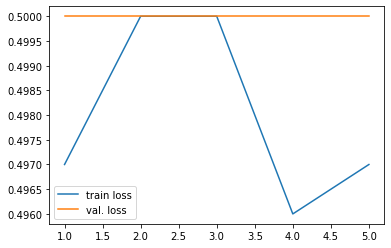

In [19]:

# importing package
import matplotlib.pyplot as plt
  
# create data
x = [1,2,3,4,5]
y = [0.497,0.5,0.5,0.496,0.497]
y1 = [0.5,0.5,0.5,0.5,0.5]
  
# plot lines
plt.plot(x, y, label = "train loss")
plt.plot(x, y1, label = "val. loss")
print("Preprocessed data, LR = 1e-4 : ")
plt.legend()
plt.show()